<a href="https://colab.research.google.com/github/CIA-Oceanix/DLCourse_MOi_2022/blob/main/notebooks/notebook_MNIST_classification_MLP_CNN_TransferLearning_with_correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep classification on Fashion-MNIST using pytorch


---



## 1- Data management <a class="anchor" id="section_1"></a>

Start with these lines of code to automatically download the Fashion-MNIST dataset.

In [1]:
from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.ToTensor()

#train_data = datasets.FashionMNIST(root = 'data', train = True, download = True, transform = transform)
#test_data = datasets.FashionMNIST(root = 'data', train = False, download = True, transform = transform)

train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [2]:
train_data.train_labels

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([5, 0, 4,  ..., 5, 6, 8])

In [3]:
# keep a subset of the training dataset
#evens = list(range(0, len(train_data), 4))

#train_data = torch.utils.data.Subset(train_data, evens)


#### **Size and structure of MNIST Datasets** - MNIST (Fashion-MNIST) is a dataset consisting of a training set of A examples and a test set of B examples. Each example is a CxC grayscale image, associated with a label from D classes. What are the values for A, B, C and D? <a class="anchor" id="question_1_1"></a>

In [4]:
num_train, num_test = len(train_data), len(test_data) # TO DO
print('A =', num_train) # TO DO
print('B =', num_test) # TO DO
print('C =', train_data.data.shape[1]) # TO DO
print('D =', len(train_data.classes)) # TO DO

A = 60000
B = 10000
C = 28
D = 10


#### **Recover the labels of the classes** of MNIST dataset

In [5]:
class_names = train_data.classes
print(class_names)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


#### **Dataloader creation** - Check data loader documentation ([documentation](https://pytorch.org/docs/stable/data.html)) for training, validation and test sets. <a class="anchor" id="question_1_2"></a>

In [30]:
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

batch_size = 20
valid_size = 0.2
train_size = 0.3

def create_data_loaders(batch_size, valid_size, train_data, test_data): # FUNCTION TO BE COMPLETED

  num_train = len(train_data)
  indices = list(range(num_train))
  np.random.shuffle(indices)
  nb_train = int( np.floor(train_size * num_train ))
  split = int(np.floor(valid_size * num_train))
  train_index, valid_index = indices[split:nb_train], indices[:split]

  train_sampler = SubsetRandomSampler(train_index)
  valid_sampler = SubsetRandomSampler(valid_index)

  train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = train_sampler)
  valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = valid_sampler)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)

  return train_loader, valid_loader, test_loader

In [7]:
train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, train_data, test_data) # TO DO

#### **MNIST samples** - Visualize some images from the training set with corresponding ground truth labels. <a class="anchor" id="question_1_3"></a>

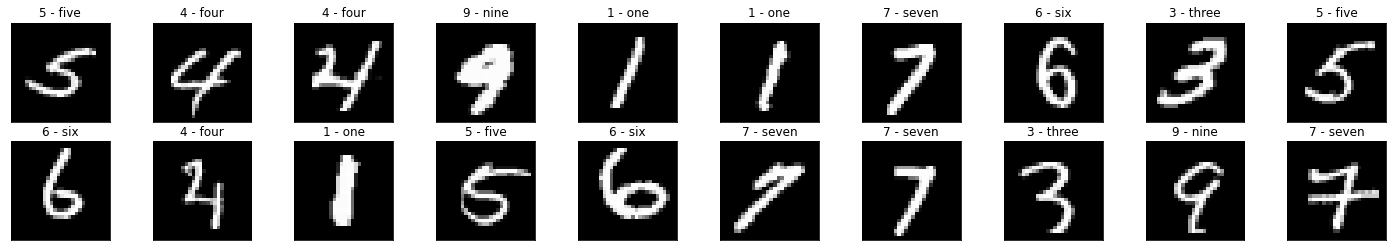

In [8]:
# CELL TO BE COMPLETED
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

data_iter = iter(train_loader)
images, labels = data_iter.next()
images = images.numpy()
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(class_names[labels[idx].item()]))

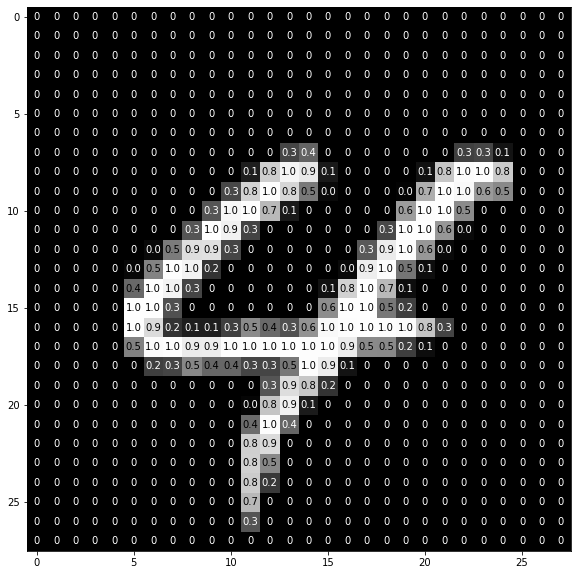

In [9]:
# CELL TO BE COMPLETED
img = np.squeeze(images[1])
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],1) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x), horizontalalignment='center', verticalalignment='center', color='white' if img[x][y]<thresh else 'black')

## 2- Multi-Layer Perceptron (MLP) <a class="anchor" id="section_2"></a>

First, let us use a multi-layer perceptron (MLP) to automatically classify Fashion-MNIST images.

#### **MLP architecture** - Define a MPL architecture with (at least) 2 fully-connected as well as dropout layers. <a class="anchor" id="question_2_1"></a>

In [31]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module): 
    def __init__(self): # FUNCTION TO BE COMPLETED
        super(MLP,self).__init__()
        hidden_1, hidden_2 = 512, 256
        self.fc1 = nn.Linear(28*28, hidden_1)
        self.fc2 = nn.Linear(hidden_1,hidden_2)
        self.fc3 = nn.Linear(hidden_2,10)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self,x): # FUNCTION TO BE COMPLETED
        x = x.view(-1,28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

#### **Traning scheme** - Train the pre-defined MLP network with cross entropy as loss function and stochastic gradient descent as optimization algorithm. <a class="anchor" id="question_2_2"></a>

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))

Using device cuda


In [ ]:
model_1 = MLP()
model_1.to(device=device)

MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [32]:
criterion = nn.CrossEntropyLoss() # TO DO

In [ ]:
optimizer = torch.optim.SGD(model_1.parameters(),lr = 0.01) # TO DO

In [22]:
n_epochs = 30

def training(n_epochs, train_loader, valid_loader, model, criterion, optimizer): # FUNCTION TO BE COMPLETED

  train_losses, valid_losses = [], []
  valid_loss_min = np.Inf

  for epoch in range(n_epochs):
      train_loss, valid_loss = 0, 0
      
      model.train()
      for data, label in train_loader:
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.long)
          optimizer.zero_grad()
          output = model(data)
          loss = criterion(output, label)
          loss.backward()
          optimizer.step()
          train_loss += loss.item() * data.size(0)
      
      model.eval()
      for data, label in valid_loader:
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.long)
          with torch.no_grad():
              output = model(data)
          loss = criterion(output,label)
          valid_loss += loss.item() * data.size(0)

      train_loss /= len(train_loader.sampler)
      valid_loss /= len(valid_loader.sampler)
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)
      
      print('epoch: {} \ttraining Loss: {:.6f} \tvalidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

      if valid_loss <= valid_loss_min:
          print('validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          valid_loss))
          torch.save(model.state_dict(), 'model.pt')
          valid_loss_min = valid_loss
      
  return train_losses, valid_losses      

In [ ]:
train_losses_1, valid_losses_1 = training(n_epochs, train_loader, valid_loader, model_1, criterion, optimizer) # TO DO

epoch: 1 	training Loss: 2.229213 	validation Loss: 2.099458
validation loss decreased (inf --> 2.099458).  Saving model ...
epoch: 2 	training Loss: 1.788177 	validation Loss: 1.324538
validation loss decreased (2.099458 --> 1.324538).  Saving model ...
epoch: 3 	training Loss: 1.046301 	validation Loss: 0.752196
validation loss decreased (1.324538 --> 0.752196).  Saving model ...
epoch: 4 	training Loss: 0.727481 	validation Loss: 0.566674
validation loss decreased (0.752196 --> 0.566674).  Saving model ...
epoch: 5 	training Loss: 0.590434 	validation Loss: 0.483046
validation loss decreased (0.566674 --> 0.483046).  Saving model ...
epoch: 6 	training Loss: 0.513643 	validation Loss: 0.439522
validation loss decreased (0.483046 --> 0.439522).  Saving model ...
epoch: 7 	training Loss: 0.478332 	validation Loss: 0.402035
validation loss decreased (0.439522 --> 0.402035).  Saving model ...
epoch: 8 	training Loss: 0.443324 	validation Loss: 0.383758
validation loss decreased (0.40203

#### **Check the training convergence** - Plot the evolution of the loss function for both training and validation sets with respect to epochs to study the convergence of the training process. <a class="anchor" id="question_2_3"></a>

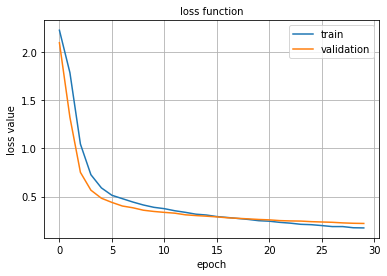

In [ ]:
# CELL TO BE COMPLETED
plt.plot(range(n_epochs), train_losses_1)
plt.plot(range(n_epochs), valid_losses_1)
plt.legend(['train', 'validation'], prop={'size': 10})
plt.title('loss function', size=10)
plt.xlabel('epoch', size=10)
plt.ylabel('loss value', size=10)
plt.grid()

Let us load the model corresponding to the lowest validation loss.

In [ ]:
model_1.load_state_dict(torch.load('model.pt', map_location=device))

<All keys matched successfully>

#### **Testing the trained MLP model ** - Test the best model on (unseen) test data and evaluate it’s performance in terms of overall and per-class accuracy scores. <a class="anchor" id="question_2_4"></a>

In [23]:
def evaluation(model, test_loader, criterion): # FUNCTION TO BE COMPLETED

  test_loss = 0.0
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))

  model.eval()
  for data, label in test_loader:
      data = data.to(device=device, dtype=torch.float32)
      label = label.to(device=device, dtype=torch.long)
      with torch.no_grad():
          output = model(data)
      loss = criterion(output, label)
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1)
      correct = np.squeeze(pred.eq(label.data.view_as(pred)))
      for i in range(len(label)):
          digit = label.data[i]
          class_correct[digit] += correct[i].item()
          class_total[digit] += 1

  test_loss = test_loss/len(test_loader.sampler)
  print('test Loss: {:.6f}\n'.format(test_loss))
  for i in range(10):
      print('test accuracy of %s: %2d%% (%2d/%2d)' % (class_names[i], 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
  print('\ntest accuracy (overall): %2.2f%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))

In [ ]:
evaluation(model_1, test_loader, criterion) # TO DO

test Loss: 0.215177

test accuracy of 0 - zero: 98% (965/980)
test accuracy of 1 - one: 97% (1112/1135)
test accuracy of 2 - two: 93% (964/1032)
test accuracy of 3 - three: 93% (943/1010)
test accuracy of 4 - four: 92% (904/982)
test accuracy of 5 - five: 90% (810/892)
test accuracy of 6 - six: 95% (913/958)
test accuracy of 7 - seven: 94% (971/1028)
test accuracy of 8 - eight: 86% (840/974)
test accuracy of 9 - nine: 91% (922/1009)

test accuracy (overall): 93.44% (9344/10000)


#### **Uncorrect classifications** - Visualize some incorrect predictions by displaying test images and labels in the format: "predicted (ground-truth)". <a class="anchor" id="question_2_5"></a>

In [ ]:
def get_all_prediction(model, loader): # FUNCTION TO BE COMPLETED
    preds = torch.tensor([], dtype=torch.long)
    targets = torch.tensor([], dtype=torch.long)
    for data, label in loader:
        data = data.to(device=device, dtype=torch.float32)
        label = label.to(device=device, dtype=torch.long)
        with torch.no_grad():
            output = model(data)
        targets = torch.cat((targets, label.cpu()), dim = 0)
        preds = torch.cat((preds, torch.max(output.cpu(), 1)[1]), dim = 0)
    return targets.numpy(), preds.numpy()

In [ ]:
targets, preds_1 = get_all_prediction(model_1, test_loader) # TO DO

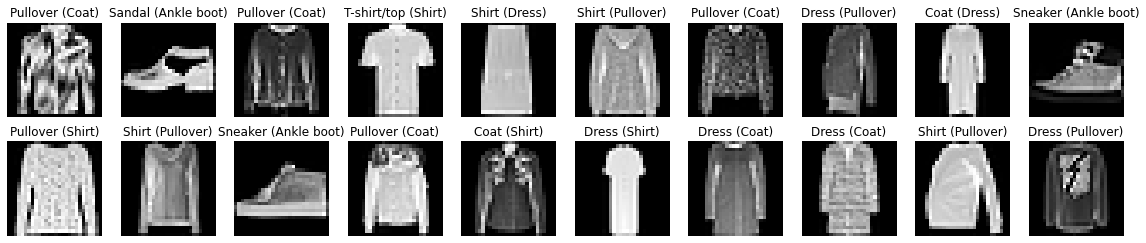

In [ ]:
index = np.where(preds_1 - targets != 0)[0]
test_set_array = test_data.data.numpy()
plt.figure(figsize=(20, 4))
for i in range(20):
  plt.subplot(2, 10, i + 1)
  plt.axis('off')
  plt.imshow(test_set_array[index[i],:,:], cmap='gray')
  plt.title("{} ({})".format(class_names[preds_1[index[i]]], class_names[targets[index[i]]]))
plt.show()

## 3- Convolutional neural network (CNN) <a class="anchor" id="section_3"></a>

Let us now switch from MLP to convolutional neural network (CNN) to classify Fashion-MNIST images.

#### **CNN architecture** - Define a CNN architecture using (at least) 2 patterns [CONV - CONV - POOL] as well as dropout and fully-connected layers. <a class="anchor" id="question_3_1"></a>

In [ ]:
class CNN(nn.Module):

    def __init__(self): # FUNCTION TO BE COMPLETED
        super(CNN,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.maxp1 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.relu4 = nn.ReLU()
        self.maxp2 = nn.MaxPool2d(kernel_size=2)
        self.drop1 = nn.Dropout(0.25)

        self.fcon1 = nn.Linear(64*4*4, 128)
        self.relu5 = nn.ReLU()
        self.drop2 = nn.Dropout(0.5)
        self.fcon2 = nn.Linear(128, 10)

    def forward(self,x): # FUNCTION TO BE COMPLETED
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.maxp1(out)
        out = self.conv3(out)
        out = self.relu3(out)
        out = self.conv4(out)
        out = self.relu4(out)
        out = self.maxp2(out)
        out = self.drop1(out)
        out = out.view(out.size(0), -1)
        out = self.fcon1(out)
        out = self.relu5(out)
        out = self.drop2(out)
        out = self.fcon2(out)
        return out

In [ ]:
from torchsummary import summary

model_2 = CNN()
model_2.to(device=device)

summary(model_2, (1, 28, 28)) # TO DO

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,496
              ReLU-4           [-1, 64, 24, 24]               0
         MaxPool2d-5           [-1, 64, 12, 12]               0
            Conv2d-6           [-1, 64, 10, 10]          36,928
              ReLU-7           [-1, 64, 10, 10]               0
            Conv2d-8             [-1, 64, 8, 8]          36,928
              ReLU-9             [-1, 64, 8, 8]               0
        MaxPool2d-10             [-1, 64, 4, 4]               0
          Dropout-11             [-1, 64, 4, 4]               0
           Linear-12                  [-1, 128]         131,200
             ReLU-13                  [-1, 128]               0
          Dropout-14                  [

#### **CNN training scheme** - Train the pre-defined CNN network with cross entropy as loss function and stochastic gradient descent as optimization algorithm. <a class="anchor" id="question_3_3"></a>

In [ ]:
optimizer = torch.optim.SGD(model_2.parameters(),lr = 0.01) # TO DO

In [ ]:
train_losses_2, valid_losses_2 = training(n_epochs, train_loader, valid_loader, model_2, criterion, optimizer) # TO DO

epoch: 1 	training Loss: 1.435236 	validation Loss: 0.694411
validation loss decreased (inf --> 0.694411).  Saving model ...
epoch: 2 	training Loss: 0.690325 	validation Loss: 0.537950
validation loss decreased (0.694411 --> 0.537950).  Saving model ...
epoch: 3 	training Loss: 0.598338 	validation Loss: 0.487100
validation loss decreased (0.537950 --> 0.487100).  Saving model ...
epoch: 4 	training Loss: 0.550084 	validation Loss: 0.454402
validation loss decreased (0.487100 --> 0.454402).  Saving model ...
epoch: 5 	training Loss: 0.512459 	validation Loss: 0.415126
validation loss decreased (0.454402 --> 0.415126).  Saving model ...
epoch: 6 	training Loss: 0.481686 	validation Loss: 0.404406
validation loss decreased (0.415126 --> 0.404406).  Saving model ...
epoch: 7 	training Loss: 0.452056 	validation Loss: 0.376474
validation loss decreased (0.404406 --> 0.376474).  Saving model ...
epoch: 8 	training Loss: 0.429007 	validation Loss: 0.357949
validation loss decreased (0.37647

#### **Training convergence** - Display in a single graph the loss functions for training and validation sets obtained with both MLP and CNN models. <a class="anchor" id="question_3_4"></a>

Text(0, 0.5, 'loss value')

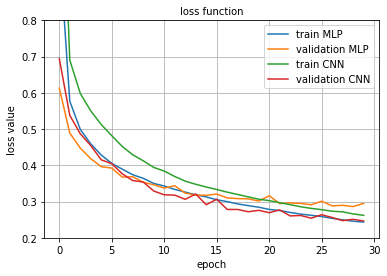

In [ ]:
# CELL TO BE COMPLETED
plt.plot(range(n_epochs), train_losses_1)
plt.plot(range(n_epochs), valid_losses_1)
plt.plot(range(n_epochs), train_losses_2)
plt.plot(range(n_epochs), valid_losses_2)
plt.ylim([0.2,0.8])
plt.grid()
plt.legend(['train MLP', 'validation MLP', 'train CNN', 'validation CNN'], prop={'size': 10})
plt.title('loss function', size=10)
plt.xlabel('epoch', size=10)
plt.ylabel('loss value', size=10)

As previously, we load the model corresponding to the lowest validation loss.

In [ ]:
model_2.load_state_dict(torch.load('model.pt', map_location=device))

<All keys matched successfully>

#### **Testing a trained CNN model** - Test the model on test data and evaluate it through overall and per-class accuracy scores. Compare these scores with the ones obtained using MLP. <a class="anchor" id="question_3_5"></a>

In [ ]:
evaluation(model_2, test_loader, criterion) # TO DO

test Loss: 0.256017

test accuracy of T-shirt/top: 87% (870/1000)
test accuracy of Trouser: 97% (978/1000)
test accuracy of Pullover: 86% (866/1000)
test accuracy of Dress: 90% (907/1000)
test accuracy of Coat: 89% (898/1000)
test accuracy of Sandal: 97% (975/1000)
test accuracy of Shirt: 67% (673/1000)
test accuracy of Sneaker: 96% (967/1000)
test accuracy of Bag: 97% (975/1000)
test accuracy of Ankle boot: 96% (963/1000)

test accuracy (overall): 90.72% (9072/10000)


#### **Incorrect classifications** - Display CNN results for images whose prediction was incorrect with MLP. Labels should be indicated in the following format: "CNN label (ground-truth)" in red if wrong, green otherwise. <a class="anchor" id="question_3_6"></a>

In [ ]:
targets, preds_2 = get_all_prediction(model_2, test_loader) # TO DO

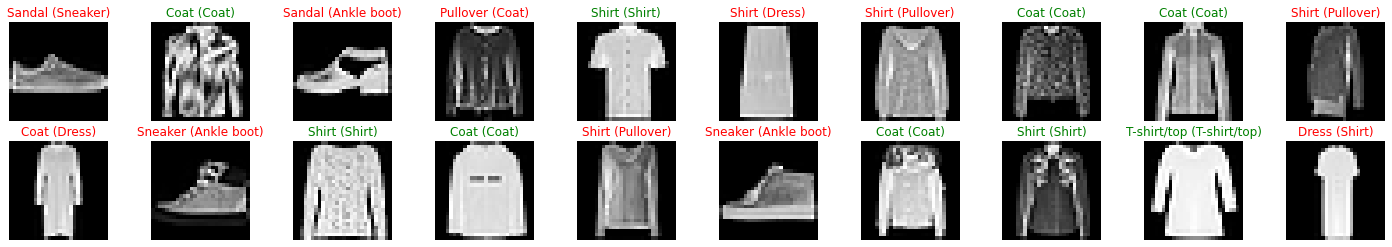

In [ ]:
plt.figure(figsize=(25, 4))
for i in range(20):
  plt.subplot(2, 10, i + 1)
  plt.axis('off')
  plt.imshow(test_set_array[index[i],:,:], cmap='gray')
  plt.title("{} ({})".format(class_names[preds_2[index[i]]], class_names[targets[index[i]]]), color=("green" if preds_2[index[i]]==targets[index[i]] else "red")) 
plt.show()

#### **Confusion matrix** - Display the confusion matrix for both MLP and CNN models. <a class="anchor" id="question_3_7"></a>

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='confusion matrix', cmap=plt.cm.Blues):
    # This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("normalized confusion matrix")
    else:
        print('confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('true label')
    plt.xlabel('predicted label')

normalized confusion matrix
normalized confusion matrix


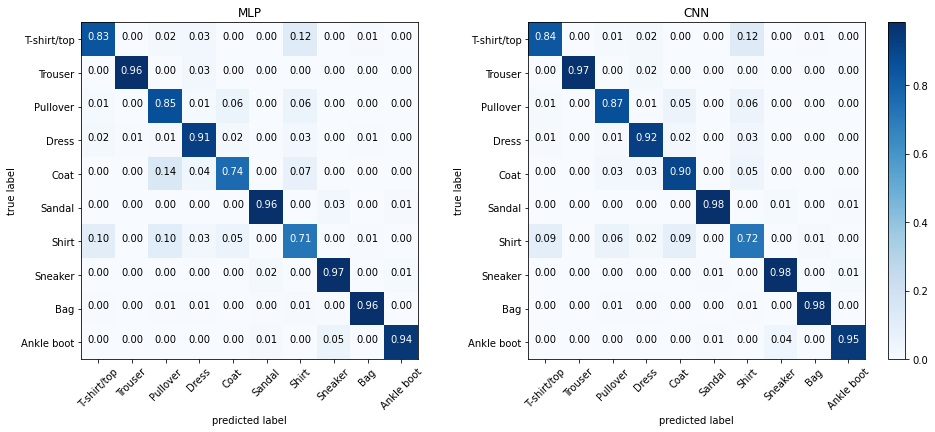

In [ ]:
# compute confusion matrix
cnf_matrix_MLP = confusion_matrix(targets, preds_1)
cnf_matrix_CNN = confusion_matrix(targets, preds_2)
np.set_printoptions(precision=2)

# plot normalized confusion matrixes
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cnf_matrix_MLP, classes=class_names, normalize=True, title='MLP')
plt.subplot(1, 2, 2)
plot_confusion_matrix(cnf_matrix_CNN, classes=class_names, normalize=True, title='CNN')
plt.show()

## 4- Transfer learning from ImageNet <a class="anchor" id="section_4"></a>

Transfer learning focuses on storing knowledge gained while solving one problem and applying it to a different but related problem.

Our goal is to use a (well-known) CNN architecture whose weights have been already trained on ImageNet to perform transfer learning and fine tuning. ImageNet is a large visual database designed for visual object recognition purposes wich contains more than 14 million images!

### **Resize MNIST dataset**: Modify the Fashion-MNIST dataset to make it fit to ImageNet by extending Fashion-MNIST images from greyscale to 3-channels images. Since the minimal image dimension as inputs of pre-trained CNN models is 48x48, you will also need to resize images. To do so, use transform.Compose(), transforms.Resize() and transforms.Grayscale(). More details on image transformations are available in the documentation.

In [10]:
transform = transforms.Compose([transforms.Resize(48), transforms.Grayscale(3), transforms.ToTensor()]) # TO DO

train_data = datasets.FashionMNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.FashionMNIST(root = 'data', train = False, download = True, transform = transform)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Create training, validation and test data loaders. Check the dimensions of images arising from the modified Fasion-MNIST dataset.

In [11]:
train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, train_data, test_data)
data_iter = iter(train_loader) 
images, labels = data_iter.next()
print(images.numpy().shape)

(20, 3, 48, 48)


#### **VGG16 model** - Exploit a vgg16 architecture ([related paper](https://arxiv.org/pdf/1409.1556.pdf)) pre-trained on ImageNet to improve the classification scores on Fashion-MNIST through fine-tuning. See the [documentation](https://pytorch.org/vision/stable/models.html#id2) for further details. Use summary() from torchsummary to describe each of the vgg16 layers. To avoid a too long learning time, you may use only 5 epochs during fine-tuning. <a class="anchor" id="question_4_3"></a>

In [26]:
import torchvision.models as models
from torchsummary import summary

model_3 = models.vgg16(pretrained=True) # TO DO
model_3.to(device=device)
summary(model_3, (3, 48, 48))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           1,792
              ReLU-2           [-1, 64, 48, 48]               0
            Conv2d-3           [-1, 64, 48, 48]          36,928
              ReLU-4           [-1, 64, 48, 48]               0
         MaxPool2d-5           [-1, 64, 24, 24]               0
            Conv2d-6          [-1, 128, 24, 24]          73,856
              ReLU-7          [-1, 128, 24, 24]               0
            Conv2d-8          [-1, 128, 24, 24]         147,584
              ReLU-9          [-1, 128, 24, 24]               0
        MaxPool2d-10          [-1, 128, 12, 12]               0
           Conv2d-11          [-1, 256, 12, 12]         295,168
             ReLU-12          [-1, 256, 12, 12]               0
           Conv2d-13          [-1, 256, 12, 12]         590,080
             ReLU-14          [-1, 256,

In [27]:
optimizer = torch.optim.SGD(model_3.parameters(),lr = 0.01) # TO DO

In [ ]:
n_epochs = 5
train_losses_3, valid_losses_3 = training(n_epochs, train_loader, valid_loader, model_3, criterion, optimizer) # TO DO

epoch: 1 	training Loss: 1.192147 	validation Loss: 0.558585
validation loss decreased (inf --> 0.558585).  Saving model ...
epoch: 2 	training Loss: 0.423269 	validation Loss: 0.429915
validation loss decreased (0.558585 --> 0.429915).  Saving model ...
epoch: 3 	training Loss: 0.310229 	validation Loss: 0.337277
validation loss decreased (0.429915 --> 0.337277).  Saving model ...
epoch: 4 	training Loss: 0.242591 	validation Loss: 0.449967


In [ ]:
# Reload best model
model_3.load_state_dict(torch.load('model.pt', map_location=device))

In [ ]:
evaluation(model_3, test_loader, criterion) # TO DO

In [ ]:
targets, preds_3 = get_all_prediction(model_3, test_loader) # TO DO

In [ ]:
# CELL TO BE COMPLETED
plt.figure(figsize=(25, 4))
for i in range(20):
  plt.subplot(2, 10, i + 1)
  plt.axis('off')
  plt.imshow(test_set_array[index[i],:,:], cmap='gray')
  plt.title("{} ({})".format(class_names[preds_3[index[i]]], class_names[targets[index[i]]]), color=("green" if preds_3[index[i]]==targets[index[i]] else "red")) 
plt.show()